In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import matplotlib as mpl
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.distributions import MultivariateNormal
import numpy as np

from pyod.models.lof import LOF

from nf_loe.nf.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nf_loe.nf.spline_flows import NSF_AR, NSF_CL
from nf_loe.data import SyntheticDataset
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from nf_loe.nf.trainer import Trainer
from torch.utils.data import DataLoader

In [2]:
# setup
n_flows = 8
max_epochs = 500
batch_size = 1024
num_rows = 1024 * 10
contamination = .05

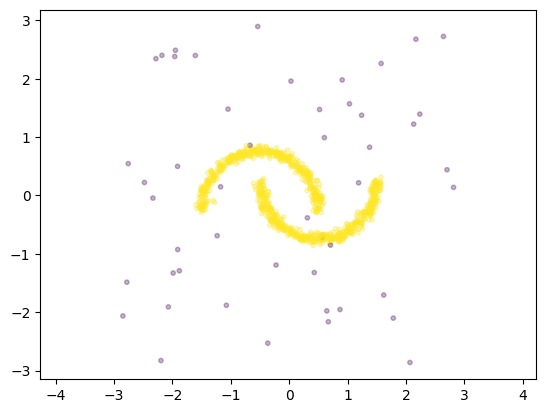

In [3]:
data = SyntheticDataset(num_rows, contamination=contamination)
train_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
sample = data[:1000]
X = sample['sample']
y = sample['label']
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, alpha=.3)
plt.axis('equal')
plt.show()

In [4]:
# Vanilla model
vanilla_prior = MultivariateNormal(torch.zeros(2), torch.eye(2), validate_args=False)
# flow = RealNVP
vanilla_flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(n_flows)]

# MAF (with MADE net, so we get very fast density estimation)
# vanilla_flows = [MAF(dim=2, parity=i%2) for i in range(n_flows)]

# construct the model
vanilla_model = NormalizingFlowModel(vanilla_prior, vanilla_flows)
# optimizer
vanilla_optimizer = optim.Adam(vanilla_model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in vanilla_model.parameters()))

# LOE model
loe_prior = MultivariateNormal(torch.zeros(2), torch.eye(2), validate_args=False)
# flow = RealNVP
loe_flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(n_flows)]

# MAF (with MADE net, so we get very fast density estimation)
# loe_flows = [MAF(dim=2, parity=i%2) for i in range(n_flows)]

# construct the model
loe_model = NormalizingFlowModel(loe_prior, loe_flows)
# optimizer
loe_optimizer = optim.Adam(loe_model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in loe_model.parameters()))

number of params:  20368
number of params:  20368


In [5]:
def vanilla_loss(z):
    zs, prior_logprob, log_det = z
    loss_n = (prior_logprob + log_det)
    loss_a = torch.log(1 - torch.exp(loss_n))
    return loss_n, loss_a

config = {
    'train_method': 'loe_hard', # blind, loe_hard, loe_soft, refine, gt
    'training_epochs': max_epochs,
    'device': 'cpu'
}
loe_optimizer = optim.Adam(loe_model.parameters(), lr=1e-4, weight_decay=1e-5)
train = Trainer(loe_model, vanilla_loss, config)

In [6]:
loss_list = train.train(
    train_loader=train_loader,
    contamination=contamination,
    optimizer=loe_optimizer,
    log_every=50
)
plt.plot(loss_list)

Epoch: 1, TR loss: 2.7279157638549805
Epoch: 50, TR loss: 1.9598438262939453
Epoch: 100, TR loss: 1.515261745452881
Epoch: 150, TR loss: 1.1635994911193848
Epoch: 200, TR loss: 1.0494430541992188
Epoch: 250, TR loss: 1.002481174468994
Epoch: 300, TR loss: 0.9747443199157715
Epoch: 350, TR loss: 0.9577444076538086
Epoch: 400, TR loss: 0.9425990104675293
Epoch: 450, TR loss: 0.9316246032714843
Epoch: 500, TR loss: 0.9233206748962403


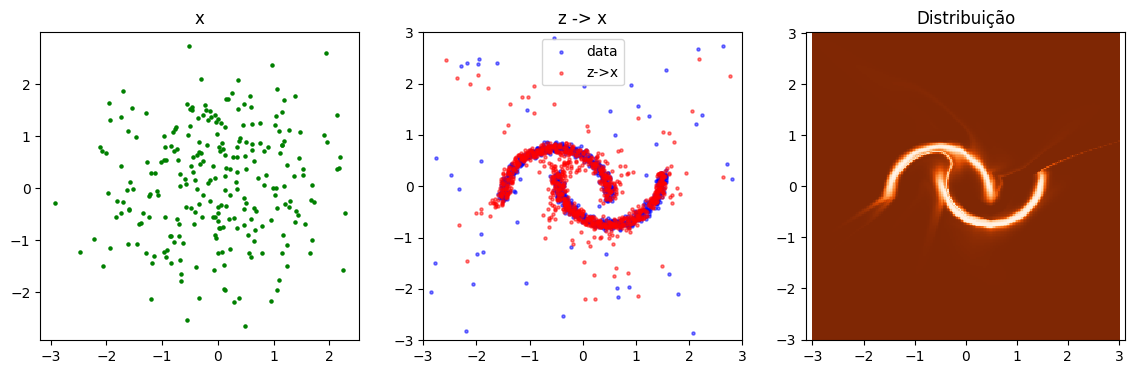

In [8]:
loe_model.eval()

zs, prior_logprob, log_det = loe_model(X)
z = zs[-1]


z = z.detach().numpy()
p = loe_model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
# plt.xlim([-3, 3])
# plt.ylim([-3, 3])
plt.title('x')

zs = loe_model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(132)
plt.scatter(X[:,0], X[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('z -> x')

loe_model.eval()
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
# log_prob = prior.log_prob(zz).to('cpu').view(*xx.shape)
zs, prior_logprob, log_det = loe_model(zz)

plt.subplot(133)
plt.pcolormesh(xx, yy, torch.exp(prior_logprob + log_det).view(*xx.shape).detach().numpy(), cmap=mpl.cm.Oranges_r)
plt.gca().set_aspect('equal')
# plt.xlim([-2, 3])
# plt.ylim([-2, 3])
plt.axis('equal')
plt.title('Distribuição')
plt.show()

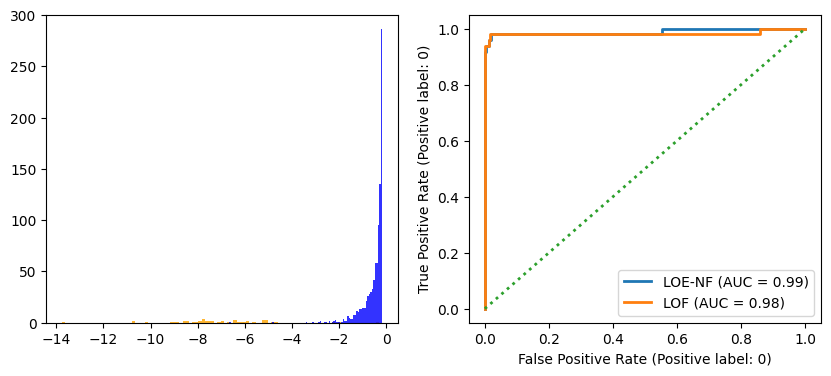

In [9]:
loe_model.eval()


plt.figure(figsize=(10,4))

# x, y = data.sample(10000)
zs, prior_logprob, log_det = loe_model(X)

probs = (prior_logprob + log_det).detach().numpy()
plt.subplot(121)
plt.hist(probs[y.squeeze().detach().numpy() == 0], bins=100, color='orange', alpha=.8)
plt.hist(probs[y.squeeze().detach().numpy() == 1], bins=100, color='blue', alpha=.8)



ax = plt.subplot(122)
# LOE NF
y_hat = -probs
RocCurveDisplay.from_predictions(
    y,
    y_hat,
    pos_label=0,
    name='LOE-NF',
    linewidth=2,
    ax = ax
)
# Vanilla NF
# vanilla_model.eval()
# zs, prior_logprob, log_det = vanilla_model(x)
# RocCurveDisplay.from_predictions(
#     y,
#     -(prior_logprob + log_det).detach().numpy(),
#     pos_label=0,
#     name='Vanilla-NF',
#     linewidth=2,
#     ax = ax
# )


# baseline
lof = LOF(n_jobs=3)
lof.fit(X)
y_hat = lof.decision_function(X)
RocCurveDisplay.from_predictions(
    y,
    y_hat,
    pos_label=0,
    name='LOF',
    linewidth=2,
    ax = ax
)
# random
plt.plot([0, 1], [0, 1], linewidth=2, linestyle=":")
plt.show()